In [3]:
import torchvision
import torch
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
# Use the same transforms as validation (no random cropping/flipping)
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the test split
test_dataset = datasets.Flowers102(root="data", split="test",
                                   download=True, transform=test_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")

100%|██████████| 345M/345M [00:16<00:00, 21.3MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.15MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 27.7MB/s]

Number of test samples: 6149


In [5]:
def get_flower_model(model_name="convnext_tiny", num_classes=102, pretrained=True):
        weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.convnext_tiny(weights=weights)
        # ConvNeXt uses a classifier block with a sequence of layers
        # The final linear layer is the last element in the 'classifier' head
        in_features = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(in_features, num_classes)
        return model

In [6]:
name = "convnext_tiny"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_flower_model(model_name=name, pretrained=False)

checkpoint_path = f"{name}_flowers.pt"
try:
    # Specify map_location to load CUDA-trained model on CPU
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    model.to(device)
except FileNotFoundError:
    print(f"Warning: Checkpoint {checkpoint_path} not found. Skipping model loading.")
except RuntimeError as e:
    if "PytorchStreamReader failed reading zip archive" in str(e):
        print(f"Error: Checkpoint file '{checkpoint_path}' is corrupted or not a valid PyTorch model file.")
        print("Please ensure the checkpoint file is correctly downloaded or saved.")
    else:
        print(f"An unexpected runtime error occurred: {e}")
        raise # Re-raise if it's not the specific zip archive error
except Exception as e:
    print(f"An unexpected error occurred while loading the model: {e}")

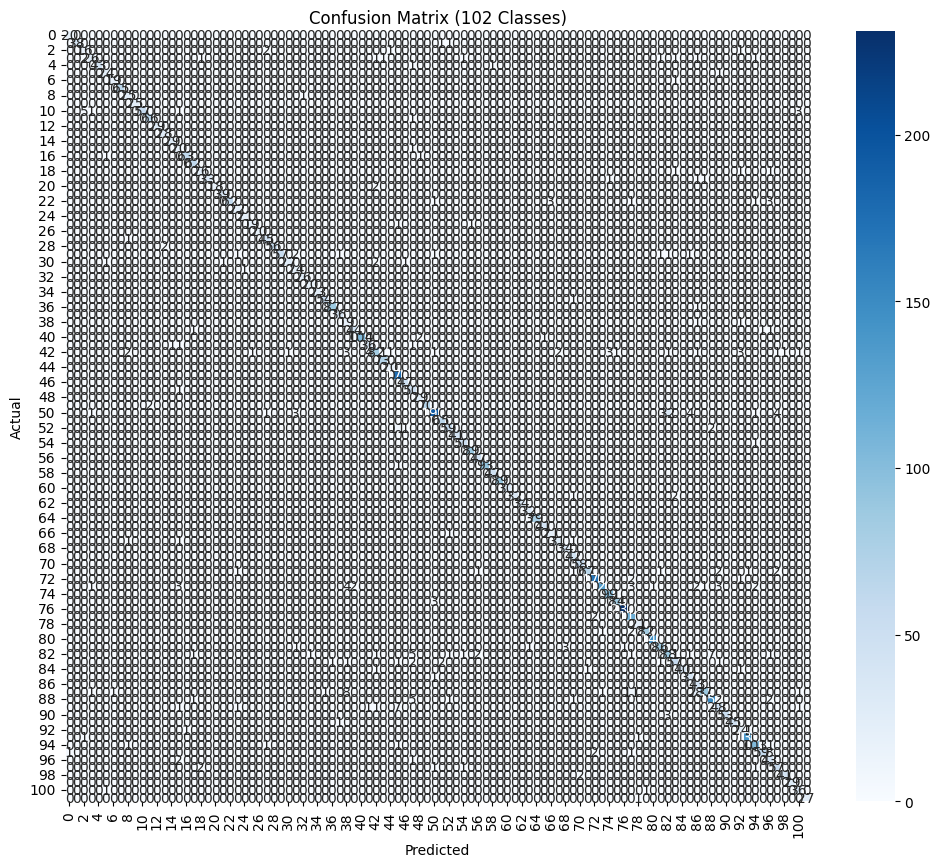

In [7]:
def perform_error_analysis(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Define device globally for error analysis
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get predictions
labels, preds = perform_error_analysis(model, test_loader, device)

# Create Confusion Matrix (showing a subset or summary)
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(12, 10))
# Plotting just a 20x20 slice for readability, or use the full cm
sns.heatmap(cm[:, :], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (102 Classes)')
plt.show()

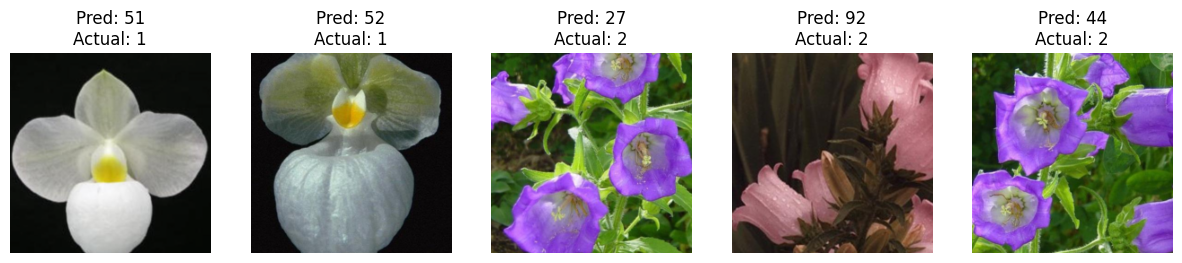

In [8]:
def plot_misclassified(model, dataset, device, num_images=5):
    model.eval()
    misclassified_imgs = []

    # We use a loader with no shuffle to map back to original images
    test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for i, (img_tensor, label) in enumerate(test_loader):
            img_tensor, label = img_tensor.to(device), label.to(device)
            output = model(img_tensor)
            pred = output.argmax(dim=1)

            if pred != label:
                # Store (image_tensor, predicted_label, actual_label)
                misclassified_imgs.append((img_tensor.cpu(), pred.item(), label.item()))

            if len(misclassified_imgs) >= num_images:
                break

    # Plotting
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, (img, p, a) in enumerate(misclassified_imgs):
        # Un-normalize for display
        img = img.squeeze().permute(1, 2, 0).numpy()
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {p}\nActual: {a}")
        axes[i].axis('off')
    plt.show()

plot_misclassified(model, test_dataset, device)

In [9]:
def detailed_classification_report(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Generating report
    report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(102)])
    print(report)

detailed_classification_report(model, test_loader, device)

              precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        20
     Class 1       1.00      0.95      0.97        40
     Class 2       0.67      0.80      0.73        20
     Class 3       0.87      0.72      0.79        36
     Class 4       1.00      0.96      0.98        45
     Class 5       0.89      0.96      0.92        25
     Class 6       0.95      0.95      0.95        20
     Class 7       1.00      1.00      1.00        65
     Class 8       0.83      0.96      0.89        26
     Class 9       1.00      1.00      1.00        25
    Class 10       1.00      0.85      0.92        67
    Class 11       0.97      0.99      0.98        67
    Class 12       1.00      1.00      1.00        29
    Class 13       0.93      1.00      0.97        28
    Class 14       0.97      1.00      0.98        29
    Class 15       0.67      0.95      0.78        21
    Class 16       0.98      0.97      0.98        65
    Class 17       0.95    

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import pandas as pd

def get_detailed_metrics(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 1. Calculate Global Metrics (Weighted to account for class imbalance)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    accuracy = accuracy_score(all_labels, all_preds)

    print("--- Global Metrics (Weighted Average) ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}\n")

    # 2. Generate a per-class DataFrame for deep inspection
    report_dict = classification_report(
        all_labels, all_preds, output_dict=True,
        target_names=[f"Class {i}" for i in range(102)]
    )

    df_report = pd.DataFrame(report_dict).transpose()
    return df_report

report_df = get_detailed_metrics(model, test_loader, device)

--- Global Metrics (Weighted Average) ---
Accuracy:  0.9376
Precision: 0.9444
Recall:    0.9376
F1-Score:  0.9379



In [11]:
# Sort by F1-score to see the 5 worst-performing classes
worst_classes = report_df.iloc[:-3, :].sort_values(by='f1-score').head(5)
print("--- 5 Worst Performing Classes ---")
print(worst_classes[['precision', 'recall', 'f1-score']])

# Sort by F1-score to see the 5 best-performing classes
best_classes = report_df.iloc[:-3, :].sort_values(by='f1-score', ascending=False).head(5)
print("\n--- 5 Best Performing Classes ---")
print(best_classes[['precision', 'recall', 'f1-score']])

--- 5 Worst Performing Classes ---
          precision    recall  f1-score
Class 38   0.542857  0.904762  0.678571
Class 2    0.666667  0.800000  0.727273
Class 86   0.589041  1.000000  0.741379
Class 82   0.704000  0.792793  0.745763
Class 87   0.977528  0.649254  0.780269

--- 5 Best Performing Classes ---
          precision  recall  f1-score
Class 9         1.0     1.0       1.0
Class 34        1.0     1.0       1.0
Class 26        1.0     1.0       1.0
Class 12        1.0     1.0       1.0
Class 7         1.0     1.0       1.0
